# Train

In [10]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from pathlib import Path
from train_test_irmas_utils import SimpleMelNpyDataset, pad_time_axes
from src.models import CNNVarTime   # or paste the class inline in a separate cell
import numpy as np
import random

# Repro
SEED = 1337
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# Paths / hyperparams
TRAIN_MANIFEST = "data/manifests/irmas_train_mels.csv"
CKPT_DIR = Path("saved_weights/irmas_pretrain"); CKPT_DIR.mkdir(parents=True, exist_ok=True)

EPOCHS       = 30
BATCH_SIZE   = 32
LR           = 3e-4
WEIGHT_DECAY = 1e-4
VAL_FRAC     = 0.15
DROPOUT      = 0.5
PATIENCE     = 8

# TODO: modify 
NUM_WORKERS  = 0   # set 0 (or 1). You can raise later after moving dataset/collate to a .py

# Device & AMP
if torch.backends.mps.is_available():
    DEVICE = "mps"; USE_CUDA_AMP = False; USE_MPS_AMP = True
elif torch.cuda.is_available():
    DEVICE = "cuda"; USE_CUDA_AMP = True; USE_MPS_AMP = False
else:
    DEVICE = "cpu";  USE_CUDA_AMP = False; USE_MPS_AMP = False
print("Device:", DEVICE)

Device: mps


In [11]:
DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
model = CNNVarTime(in_ch=2, num_classes=11).to(DEVICE)

ckpt = torch.load("saved_weights/irmas_pretrain/best_val_acc.pt", map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
label_to_idx = ckpt.get("label_to_idx", None)  # handy for evaluation
epochs_loaded = ckpt.get("epoch")
print("Loaded epoch:", epochs_loaded)


Loaded epoch: 24


In [12]:
# Build label map once
tmp_ds = SimpleMelNpyDataset(TRAIN_MANIFEST, train=True, per_example_norm=True)
label_to_idx = tmp_ds.label_to_idx
NUM_CLASSES = len(label_to_idx)
print("Classes:", label_to_idx)

# Full training ds (no heavy aug to keep it minimal & reproducible)
full_ds = SimpleMelNpyDataset(TRAIN_MANIFEST, label_to_idx=label_to_idx, train=True, per_example_norm=True)

# Split
N = len(full_ds); n_val = int(round(N * VAL_FRAC)); n_train = N - n_val
train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))
val_ds.dataset.train = False

# DataLoaders
pin_mem = (DEVICE == "cuda")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=pin_mem, collate_fn=pad_time_axes)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=pin_mem, collate_fn=pad_time_axes)

len(train_ds), len(val_ds)

Classes: {'cel': 0, 'cla': 1, 'flu': 2, 'gac': 3, 'gel': 4, 'org': 5, 'pia': 6, 'sax': 7, 'tru': 8, 'vio': 9, 'voi': 10}


(5699, 1006)

In [ ]:
# --- Model, optimizer, scheduler, criterion, (optional) resume ---

# If you want to start from a saved checkpoint, set this:
# RESUME_CKPT = "saved_weights/irmas_pretrain/val_0.56.pt"  # "" to train from scratch

# (Optional) resume optimizer/scheduler states too (continue same run)
RESUME_ALL  = False  # True to resume optimizer + scheduler

# Instantiate model with current NUM_CLASSES
model = CNNVarTime(in_ch=2, num_classes=NUM_CLASSES, p_drop=DROPOUT).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss()

if RESUME_CKPT:
    ckpt = torch.load(RESUME_CKPT, map_location=DEVICE)

    # If the checkpoint carries a label mapping, prefer to use it to avoid class-index drift
    ckpt_l2i = ckpt.get("label_to_idx")
    if ckpt_l2i is not None and ckpt_l2i != label_to_idx:
        # Reconcile: adopt the checkpoint's mapping and update NUM_CLASSES if needed
        label_to_idx = ckpt_l2i
        NUM_CLASSES = len(label_to_idx)
        # If NUM_CLASSES changed, rebuild the model head accordingly
        model = CNNVarTime(in_ch=2, num_classes=NUM_CLASSES, p_drop=DROPOUT).to(DEVICE)

    # Load model weights (strict=True ensures shapes match)
    model.load_state_dict(ckpt["model_state"])  # if you changed head size, set strict=False and handle missing keys

    if RESUME_ALL:
        if "opt_state" in ckpt:
            optimizer.load_state_dict(ckpt["opt_state"])
        if "sched_state" in ckpt:
            scheduler.load_state_dict(ckpt["sched_state"])
        print(f"Full resume from: {RESUME_CKPT} | epoch: {ckpt.get('epoch')}")
    else:
        print(f"Warm-started from: {RESUME_CKPT} (model weights only)")

Warm-started from: saved_weights/irmas_pretrain/val_0.56.pt (model weights only)


In [14]:
best_val_acc = 0.0
no_improve = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

use_cuda_amp = (DEVICE == "cuda")
use_mps_amp  = (DEVICE == "mps")
scaler = torch.cuda.amp.GradScaler(enabled=use_cuda_amp)

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    # ---- Train ----
    model.train()
    tr_loss = tr_acc = nb = 0
    for X, y, _ in train_loader:
        X = X.to(DEVICE, non_blocking=pin_mem); y = y.to(DEVICE, non_blocking=pin_mem)
        optimizer.zero_grad(set_to_none=True)

        if use_cuda_amp:
            with torch.cuda.amp.autocast():
                logits = model(X); loss = criterion(logits, y)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer); scaler.update()
        else:
            if use_mps_amp:
                with torch.autocast(device_type="mps", dtype=torch.float16):
                    logits = model(X); loss = criterion(logits, y)
            else:
                logits = model(X); loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

        tr_loss += loss.item()
        tr_acc  += (logits.argmax(1) == y).float().mean().item()
        nb += 1
    tr_loss /= max(1, nb); tr_acc /= max(1, nb)

    # ---- Val ----
    model.eval()
    va_loss = va_acc = nb = 0
    with torch.no_grad():
        for X, y, _ in val_loader:
            X = X.to(DEVICE, non_blocking=pin_mem); y = y.to(DEVICE, non_blocking=pin_mem)
            if use_cuda_amp:
                with torch.cuda.amp.autocast():
                    logits = model(X); loss = criterion(logits, y)
            else:
                if use_mps_amp:
                    with torch.autocast(device_type="mps", dtype=torch.float16):
                        logits = model(X); loss = criterion(logits, y)
                else:
                    logits = model(X); loss = criterion(logits, y)
            va_loss += loss.item()
            va_acc  += (logits.argmax(1) == y).float().mean().item()
            nb += 1
    va_loss /= max(1, nb); va_acc /= max(1, nb)
    scheduler.step()

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    print(f"[{epoch:03d}/{EPOCHS}] train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f} | time {time.time()-t0:.1f}s")

    # Save "last"
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "opt_state": optimizer.state_dict(),
        "sched_state": scheduler.state_dict(),
        "label_to_idx": label_to_idx,
        "history": history,
    }, CKPT_DIR / "last.pt")

    # Save "best"
    if va_acc > best_val_acc + 1e-6:
        best_val_acc = va_acc; no_improve = 0
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "opt_state": optimizer.state_dict(),
            "sched_state": scheduler.state_dict(),
            "label_to_idx": label_to_idx,
            "history": history,
        }, CKPT_DIR / "best_val_acc.pt")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch}. Best val acc {best_val_acc:.4f}")
            break

print("Best val acc:", best_val_acc)

/var/folders/9g/kj2r9l693tgcs5y__cjlbp4r0000gn/T/ipykernel_27813/523593545.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_cuda_amp)


[001/30] train 1.6473/0.4288 | val 1.4015/0.5610 | time 19.3s


KeyboardInterrupt: 

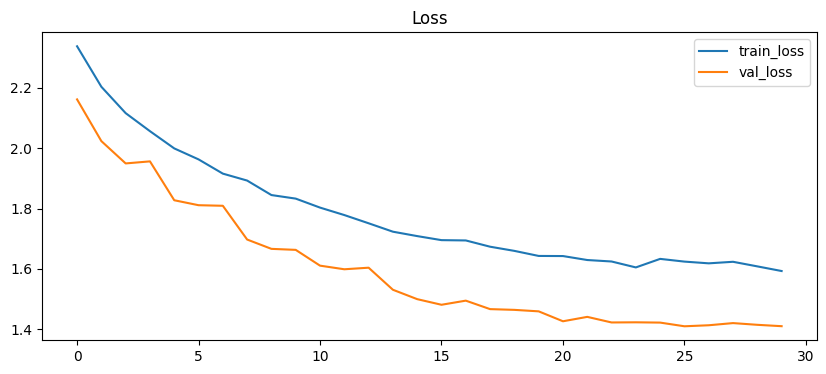

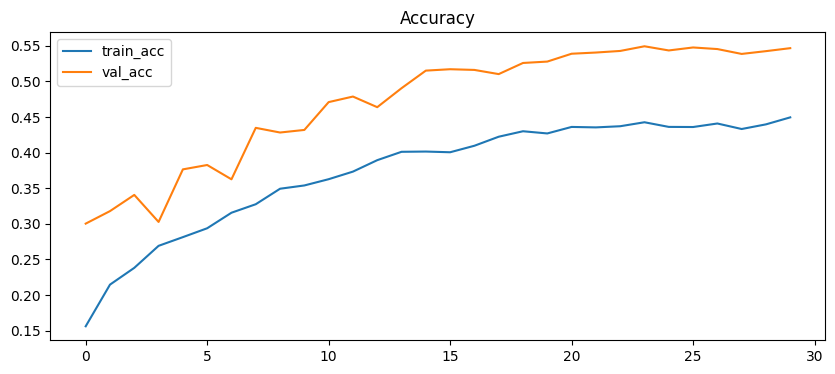

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.show()

plt.figure(figsize=(10,4))
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend(); plt.title("Accuracy"); plt.show()